This tutorial demonstrates runing Molecular Dynamics (MD) simulations on lattice systems.
First, import all the stuff we'll need

In [17]:
import os
import sys
import math
import copy

if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *
from libra_py import *

import py3Dmol   # molecular visualization
import matplotlib.pyplot as plt   # plots
%matplotlib inline 

Define a function that initializes interactions - that is it zeroes forces on all atoms (and the Hessian), as well as does the same for all of the interactions one have defined

In [18]:
def init_interactions(interactions, syst, Hess):
    """
    interactions - (list of Interaction_N_Body or derived objects). Represents interactions
    syst - (System) - Chemical system object
    Hess - (MATRIX) - A Hessian matrix

    This function sets energy, atomic stress, all forces and Hessian matrix to zero
    """

    for inter in interactions:
        inter.energy = 0.0
        inter.stress_at *= 0.0

    syst.zero_atom_forces()

    Hess *= 0.0

Once all the pairs (connections) are somehow defined for the system, one can initialize the interaction objects. So far, we can have only 2-body (2B) interactions. In particular, one of them is a harmoninc potential, which can also exist for atoms connected periodiacally - for this reason, we need to define the translation vectors. 

In [19]:
def set_interactions_2B(syst, Hess, pairs, K, dist):
    """
    This is a general setter of the 2-body interactions

    syst - (System) - Chemical system object
    Hess - (MATRIX) - Hessian 
    pairs - ([int, int, VECTOR, VECTOR]) - defines the interacting pair, the two integers are the
         indices of the atoms, the two vectors are their periodic translations
    K - (double) - force constant for the Harmonic potential of the type U = k*(r-r_0)^2
    dist - (double) - r_0 in the above equation

    Define interactions in the system. 
    Once the variables are set, the all the calculations are also run.

    """

    N_int = len(pairs)

    inter = []
        
    for i in range(N_int):
        I, J = pairs[i][0], pairs[i][1]
        inter.append( Bond_Interaction() )
        inter[i].set_functional("Harmonic")
        inter[i].set_params({"K":K, "r0":dist })
        inter[i].set_coords(syst.Atoms[I].Atom_RB.rb_cm, syst.Atoms[J].Atom_RB.rb_cm)
        inter[i].set_transl(pairs[i][2], pairs[i][3])
        inter[i].set_forces(syst.Atoms[I].Atom_RB.rb_force, syst.Atoms[J].Atom_RB.rb_force)
        inter[i].set_hessian(Hess, Py2Cpp_int([3*I, 3*I+1, 3*I+2, 3*J, 3*J+1, 3*J+2]))

    return inter

The function below will zero-out all the interactions and re-comute them again, updating the forces of the molecular system

In [20]:
def potential(interactions, syst, Hess):
    """
    interactions - (list of Interaction_N_Body or derived objects). Represents interactions
    syst - (System) - Chemical system object
    Hess - (MATRIX) - A Hessian matrix

    Compute potential energy and all related variables. This function also
    takes care of zeroing all the forces, stress, and Hessian before all the
    interactions are computed.
    """

    init_interactions(interactions, syst, Hess)

    energy = 0.0

    N = len(interactions)
    for i in range(N):
        interactions[i].compute()        

        energy = energy + interactions[i].energy
    return energy    

A function to compute kinetic energy of molecular system

In [21]:
def kinetic(syst):
    """
    syst - (System) - Chemical system object

    Compute the kinetic energy    
    """

    res = syst.ekin_tr_atom()

    return res


Finally, we are in position to define a MD procedure, which implements a simplest velocity Verlet algorithm for
MD and collects all the necessary information along the trajectory

In [22]:
def md(syst, R, MaxCoord, params):
    """
    params - a dictionary of the control parameters

    Run an MD simulation of the chain of N particles
    """

    Nx, Ny, Nz = params["Nx"], params["Ny"], params["Nz"]
    a, b, c = params["a"], params["b"], params["c"]
    Rcut = params["Rcut"]
    pbc_opt = params["pbc_opt"]

    K = params["K"]
    dist_eq = params["dist_eq"]
    is_periodic = params["is_periodic"]

    dt = params["dt"]
    Nsteps = params["Nsteps"]

    
    prms = {"Rcut":Rcut, "tv1":Nx*a, "tv2":Ny*b, "tv3":Nz*c, "pbc_opt":pbc_opt, "opt":0, "verbosity":0 }
    
    res, line, pairs = autoconnect.autoconnect(R, MaxCoord, prms) 
    print( len(pairs), " pairwise interactions exist in this system")
    Nat = len(R)  # number of atoms
   
    # "Charges"
    q = [0.0]*Nat

    # Hessian
    Hess = MATRIX(3*Nat,3*Nat)

    # Initialize the interactions
    inter = set_interactions_2B(syst, Hess, pairs, params["K"], dist_eq)

    # Compute all the energies
    epot = potential(inter, syst, Hess)
    ekin = kinetic(syst)
    etot = ekin + epot
    tim = 0.0

    
    res = [[], [], [], [], []]    
    allxyz = "" 

    ##============ MD ==============================
    mu = []

    for j in range(Nsteps):

        #====== MD: Verlet propagation ==========
        for i in range(Nat):
            syst.Atoms[i].Atom_RB.apply_force(0.5*dt)

            iM = syst.Atoms[i].Atom_RB.rb_iM
            Pi = syst.Atoms[i].Atom_RB.rb_p
            syst.Atoms[i].Atom_RB.shift_position(dt*iM*Pi)

        epot = potential(inter, syst, Hess)

        for i in range(Nat):
            syst.Atoms[i].Atom_RB.apply_force(0.5*dt)


        ekin = kinetic(syst)
        etot = ekin + epot
        tim = tim + dt

        res[0].append(tim)
        res[1].append(ekin)
        res[2].append(epot)
        res[3].append(etot)        
        allxyz = allxyz + syst.get_xyz(0, "abc", 0) #+"\n"

    return res, allxyz

Define a lattice of certain atom types and initialize these atoms' momenta randomly

In [23]:
rnd = Random()

# Unit cell parameters
a = VECTOR(2.0, 0.0, 0.0)
b = VECTOR(0.0, 2.0, 0.0)
c = VECTOR(0.0, 0.0, 2.0)

# Create a Chemical system
Nx, Ny, Nz = 10, 10, 1  # 

syst, R, MaxCoord = System(), [], []
build.add_atom_to_system(syst, R, MaxCoord, Nx,Ny,Nz, a, b, c, VECTOR(0.0, 0.0, 0.0), "H", 2000.0, VECTOR(1.0, 0.0, 0.0), 6, rnd)

Define the MD simulation parameters and perform the calculations

In [24]:
params = {"Nx":Nx, "Ny":Ny, "Nz":Nz,
          "a":a, "b":b, "c":c, "Rcut":2.001, "pbc_opt":"abc",
          "K":0.1, "dist_eq":2.0, "is_periodic":1, "dt":20.0, "Nsteps":500 
         }

res, allxyz = md(syst, R, MaxCoord, params)

200  pairwise interactions exist in this system


Visualize the nuclear dynmaics

In [25]:
view = py3Dmol.view(width=800,height=400)  # linked=False,viewergrid=(3,2)\n
view.setBackgroundColor('0xeeeeee')                                     
view.zoomTo()                                                           
view.addModelsAsFrames(allxyz, 'xyz')
view.setStyle({'sphere':{'colorscheme':'Jmol', }})                        
view.animate({'reps':0, 'loop':'forward', 'step':5})
view.show()                 

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Plot the variables computed along the trajectory - e.g. total and kinetic energies. Note the magnitue of the 
total and kinetic energies' fluctuations

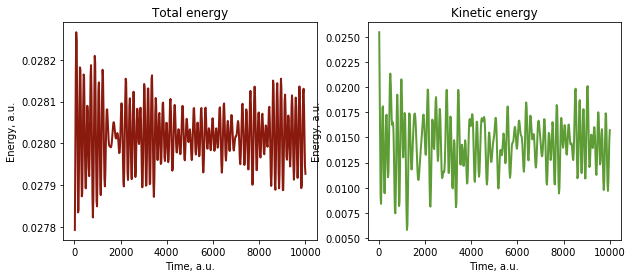

In [26]:
plt.figure(1, figsize=(10, 4)) # dpi=300, frameon=False)
plt.subplot(1,2,1)
plt.title("Total energy")
plt.xlabel('Time, a.u.')
plt.ylabel('Energy, a.u.')
plt.plot(res[0], res[3], label='Total energy', linewidth=2, color = "#8b1a0e")

plt.subplot(1,2,2)
plt.title("Kinetic energy")
plt.xlabel('Time, a.u.')
plt.ylabel('Energy, a.u.')
plt.plot(res[0], res[1], label='Kinetic', linewidth=2, color = "#5e9c36")